# Document Similarity
### Using FastText Word Embedding
https://fasttext.cc/docs/en/aligned-vectors.html

In [1]:
from gensim.models import KeyedVectors
import numpy as np

In [2]:
wiki_en_align = '../../data/fasttext/wiki.en.align.vec'
# get fasttext wiki embeddings for english
wv_wiki_en = KeyedVectors.load_word2vec_format(wiki_en_align)
print('english words {}'.format(len(list(wv_wiki_en.vocab.keys()))))

english words 2519370


In [3]:
# import postgresql
from modules.library.postgresql import PostgresQL
# connect to the postgresql database
pg = PostgresQL() 
pg.connect("eurlex", "postgres-burger")

In [37]:
documents = pg.execute("""
    SELECT * FROM documents WHERE document_celex_num='22015P0513(01)';
""")

In [38]:
documents[0]

{'document_id': 43145,
 'document_celex_num': '22015P0513(01)',
 'document_title': 'Joint Parliamentary Assembly of the Partnership Agreement concluded between the Members of the African, Caribbean and Pacific Group of States, of the one part, and the European Union and its Member States, of the other part — Minutes of the sitting of Monday, 1 December 2014',
 'document_author': 'ACP–EU Joint Parliamentary Assembly',
 'document_form': 'Notice',
 'document_date': datetime.date(2014, 12, 1),
 'document_text': '13.5.2015\xa0\xa0\xa0ENOfficial Journal of the European UnionC 160/1JOINT PARLIAMENTARY ASSEMBLY OF THE PARTNERSHIP AGREEMENT CONCLUDED BETWEEN THE MEMBERS OF THE AFRICAN, CARIBBEAN AND PACIFIC GROUP OF STATES, OF THE ONE PART, AND THE EUROPEAN UNION AND ITS MEMBER STATES, OF THE OTHER PARTMINUTES OF THE SITTING OF MONDAY, 1\xa0December 2014(2015/C 160/01)ContentsFormal inaugural sitting1Sitting of the Joint Parliamentary Assembly2Composition of the Joint Parliamentary Assembly2Acc

## Processing Data

In [39]:
# import natural language toolkit
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation
from nltk.corpus   import stopwords
from nltk.tokenize import word_tokenize

import string
# prepare stopword list
stop_words = stopwords.words('english') + list(string.punctuation)

In [40]:
import operator
def tokenize(text, stopwords):
    """Tokenizes and removes stopwords from the document"""
    
    def strip_comments(s):
        s = s.replace('"', '')
        s = s.replace("'", '')
        s = s.replace('“', '')
        s = s.replace('”', '')
        return s
    
    CUSTOM_FILTERS = [lambda x: x.lower(), strip_punctuation]
    
    stripped_text = strip_comments(text)
    tokens = preprocess_string(stripped_text, CUSTOM_FILTERS)
    filtered = [w for w in tokens if not w in stopwords]
    
    return filtered
    # get the most frequent words in the document
    count = { }
    for word in filtered:
        if word not in count:
            count[word] = 0
        count[word] += 1
    
    word_sorted = sorted(count.items(), key=operator.itemgetter(1), reverse=True)
    return word_sorted

In [41]:
document_tokens = tokenize(documents[0]['document_text'], stop_words)

In [48]:
'deforestation' in document_tokens

True

In [49]:
'deforestation' in wv_wiki_en.vocab.keys()

True

In [42]:
words = []
vectors = []
for token in set(document_tokens):
    if token in wv_wiki_en.vocab.keys():
        words.append(token)
        vectors.append(wv_wiki_en[token])  # numpy vector of a word

In [43]:
print('tokens: {}, words, {}, vectors: {}'.format(len(document_tokens), len(words), len(vectors)))

tokens: 1105, words, 545, vectors: 545


In [44]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(vectors)
X_embedded.shape

(545, 2)

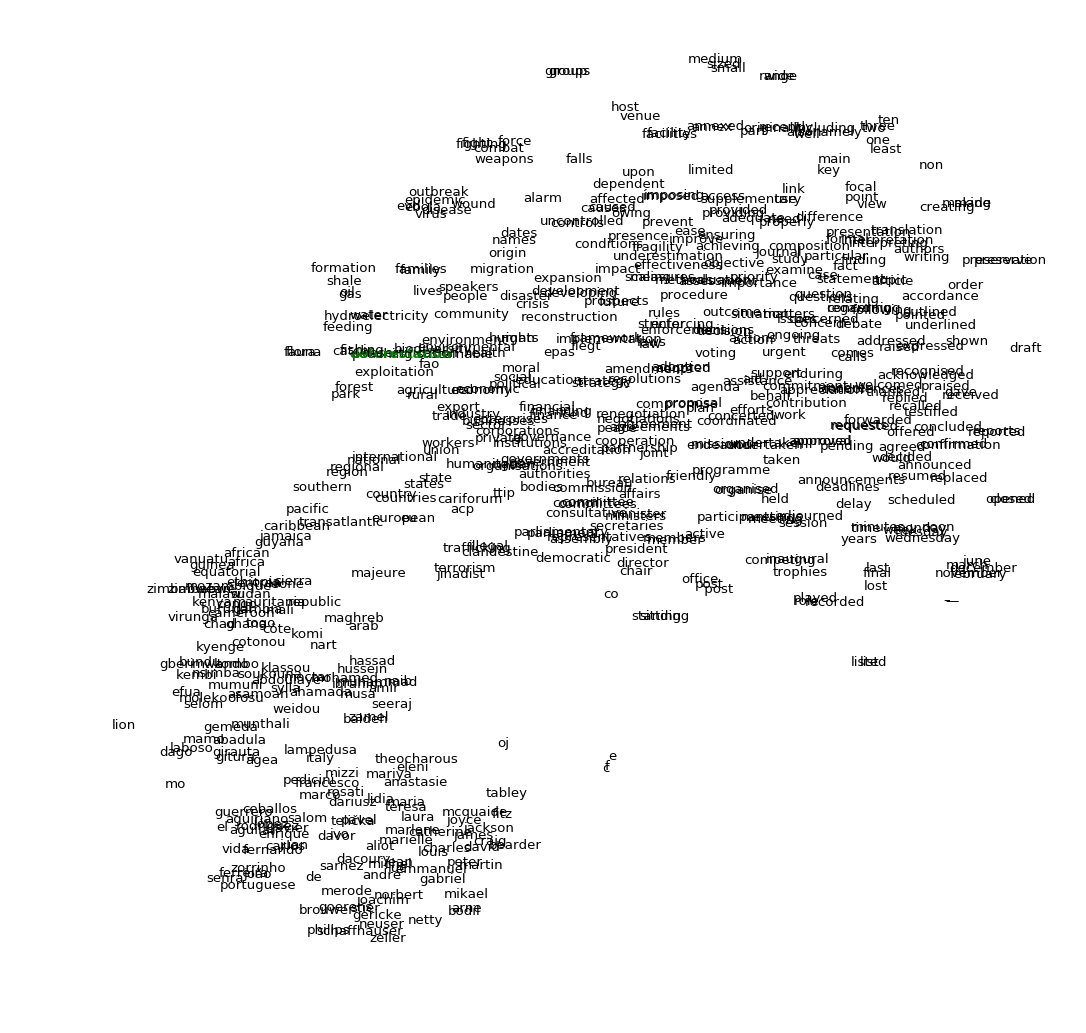

In [115]:
# import matplotlib
import matplotlib.pyplot as plt
# unit area ellipse
x, y = X_embedded.transpose()[0], X_embedded.transpose()[1]

fig, ax = plt.subplots(figsize=(8, 8), dpi=160, facecolor='w')
ax.scatter(x, y, 0)

n = words
for i, txt in enumerate(n):
    weight = 'normal'
    color = 'black'
    if txt == 'deforestation':
        weight = 'bold'
        color = 'green'
    ax.annotate(txt, (x[i], y[i]), color=color, weight=weight, ha='center', va='center', size=6)
plt.axis('off')
plt.show()

In [55]:
embedding = 0
for id, word in enumerate(words):
    if word == 'deforestation':
        embedding = X_embedded[id]
        break

In [58]:
def euclid_similarity(emb1, emb2):
    """Calculate the euclid similarity between two embeddings"""
    return np.linalg.norm(emb1 - emb2)

In [64]:
def k_nearest_neighbors(embedding, k, we=X_embedded, words=words, similarity=euclid_similarity):
    """Get the k nearest neighbors of a particular material"""
    # calculate the similarities and revert it
    sims = [similarity(embedding, w) for w in we]
    # sort and get the corresponding values and weights
    distances = []
    neighbors = []
    for c, index in enumerate(np.argsort(sims)):
        # break if we had enough values
        if c == k:
            break
        distances.append(sims[index])
        neighbors.append(words[index])
    # return the documents and weights
    return neighbors, distances

In [69]:
neighbors, distances = k_nearest_neighbors(embedding, k=20)

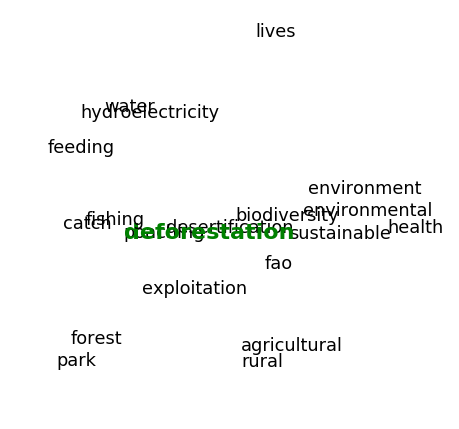

In [125]:
# import matplotlib
import matplotlib.pyplot as plt
# unit area ellipse
x, y = X_embedded.transpose()[0], X_embedded.transpose()[1]

fig, ax = plt.subplots(figsize=(3, 3), dpi=160, facecolor='w')

n = words
for i, txt in enumerate(n):
    if txt in neighbors:
        weight = 'normal'
        color = 'black'
        size = 8
        if txt == 'deforestation':
            weight = 'bold'
            color = 'green'
            size = 10
        ax.scatter(x[i], y[i], 0)
        ax.annotate(txt, (x[i], y[i]), color=color, weight=weight, ha='center', va='center', size=size)
plt.axis('off')
plt.show()

In [79]:
documents = pg.execute("""
    SELECT * FROM documents;
""")

In [83]:
def dataset_embedding(dataset, stopwords, wv, document_embedding):
    """Creates the dataset embeddings"""
    embeddings = np.zeros((len(dataset), wv.vector_size), dtype=np.float32)
    for id, document in enumerate(dataset):
        text = document['document_text']
        embeddings[id,:] = document_embedding(text, stopwords, wv)
        if id % 10000 == 0:
            print('Processed document number = {}'.format(id))
    return embeddings

In [84]:
def document_embedding_average(text, stopwords, wv):
    """Creates a document embedding by aggregating the corresponding token embeddings"""
    embedding = np.zeros(wv.vector_size, dtype=np.float32)
    
    if text is None:
        return embedding
    
    word_sorted = tokenize(text, stopwords)
    norm = 0
    for token in word_sorted:
        # sum all tokens embeddings of the vector
        if token in wv.vocab.keys():
            embedding += wv[token] 
            norm += 1
    # return the normalized embedding; if not zero
    return embedding if norm == 0 else embedding / norm

In [147]:
limit = 15000
we = dataset_embedding(documents[:limit], stop_words, wv_wiki_en, document_embedding_average)

Processed document number = 0
Processed document number = 10000


In [149]:
non_null = [x for x in we if np.linalg.norm(x) != 0]
len(non_null)

6916

In [154]:
X = TSNE(n_components=2).fit_transform(non_null)

In [161]:
XX = X[:4000, :]
XX.shape

(4000, 2)

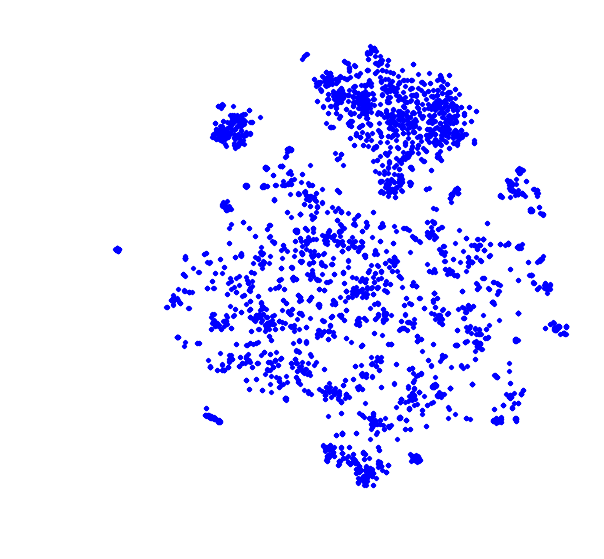

In [162]:
# get the (x, y) coordinates
x, y = XX.transpose()[0], XX.transpose()[1]
# draw the points into the landscape
fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
ax.scatter(x,  y,  2, marker='x', c='b')
# show the image
plt.axis('off')
plt.show()